**Rozdział 8. Redukcja wymiarowości**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 8._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Uruchom w Google Colab (wersja angielska)</a>
  </td>
</table>

# Konfiguracja

Importujmy najpierw kilka popularnych modułów, upewnijmy się, że będą wstawiane wykresy MatplotLib, a także przygotujmy funkcję zapisującą rysunki. Sprawdzimy także, czy jest zainstalowane środowisko Python 3.5 lub nowsze (możliwe, że kod będzie działał w środowisku Python 2.x, zostało ono jednak porzucone, dlatego zalecamy korzystanie ze środowiska Python 3), a także biblioteka Scikit-Learn 0.20 lub nowsza.

In [1]:
# Wymagane środowisko Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Wymagana biblioteka Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ścieżka zapisywania rysunków
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "R08"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignoruje niepotrzebne ostrzeżenia (sprawdź problem numer 5998 SciPy)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Metody rzutowania
Tworzymy trójwymiarowy zestaw danych:

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## Analiza PCA za pomocą rozkładu SVD

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

## Analiza PCA za pomocą modułu Scikit-Learn

Analiza PCA przy użyciu modułu Scikit-Learn to naprawdę błahostka. Wykonywany jest za nas nawet proces środkowania próbek:

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Zwróć uwagę, że kilkukrotne przeprowadzenie analizy PCA wobec nieco odmiennych zbiorów danych może dawać różne wyniki. Najczęściej jedyną różnicą jest odwrócenie niektórych osi. W tym przykładzie analiza PCA skutkuje takim samym rzutowaniem, jak w przykładzie z rozkładem SVD, z tym że obydwie osie zostały odwrócone:

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

Odczytujemy trójwymiarowe punkty rzutowane na płaszczyznę (dwuwymiarową podprzestrzeń PCA).

In [12]:
X3D_inv = pca.inverse_transform(X2D)

Oczywiście, w wyniku rzutowania nastąpiła częściowa utrata informacji, dlatego odtworzone trójwymiarowe punkty nie są identyczne z pierwotnym, trójwymiarowym zbiorem danych:

In [13]:
np.allclose(X3D_inv, X)

False

Możemy obliczyć błąd rekonstrukcji:

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

Odwrotna transformacja w technice rozkładu SVD wygląda następująco:

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

Rekonstrukcje otrzymane za pomocą obydwu metod nie są identyczne, ponieważ klasa `PCA` modułu Scikit-Learn automatycznie przeprowadza odwrócenie uśrednionego środkowania; jeżeli jednak odejmiemy od niego średnią, otrzymamy takie same rekonstrukcje:

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

Obiekt `PCA` daje nam dostęp do głównych składowych, które zostały obliczone:

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Porównajmy je z dwoma pierwszymi głównymi składowymi uzyskanymi metodą SVD:

In [18]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Jak widać, obydwie osie są odwrócone.

Sprawdźmy teraz współczynnik wariancji wyjaśnionej:

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

Pierwszy wymiar wyjaśnia 84,2% wariancji, a drugi - 14,6%.

Rzutując dane na dwuwymiarową płaszczyznę straciliśmy około 1,1% wariancji:

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Poniżej przedstawiam sposób obliczania współczynnika wariancji wyjaśnionej za pomocą metody SVD (przypominam, że wartość `s` stanowi przekątną macierzy `S`):

In [21]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

Czas wygenerować kilka ślicznych wykresów! :)

Klasa pozwalająca na rysowanie trójwymiarowych strzałek (skopiowana ze strony http://stackoverflow.com/questions/11140163)

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Wyrażamy płaszczyznę jako funkcję zmiennych x i y.

In [23]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Rysujemy wykres trójwymiarowego zbioru danych, płaszczyznę i rzutowania na tej płaszczyźnie.

Zapisywanie rysunku r_8_2


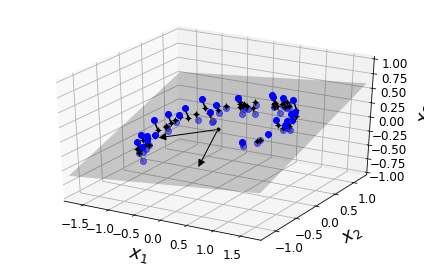

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Uwaga: jeżeli korzystasz z biblioteki Matplotlib 3.0.0, zawiera ona błąd i
# wyświetla prawidłowo wykresów trójwymiarowych.
# Więcej informacji znajdziesz na stronie https://github.com/matplotlib/matplotlib/issues/12239
# Powinieneś zaktualizować ją do nowszej wersji. Jeśli nie możesz tego zrobić, to użyj
# poniższego obejścia przed wyświetleniem każdego grafu:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("r_8_2")
plt.show()

Zapisywanie rysunku r_8_3


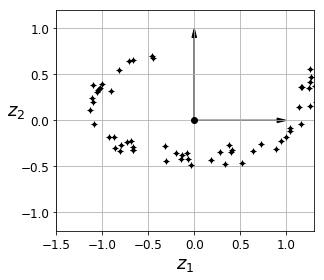

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("r_8_3")

# Uczenie rozmaitościowe
Zestaw danych Swiss roll:

In [26]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Zapisywanie rysunku r_8_4


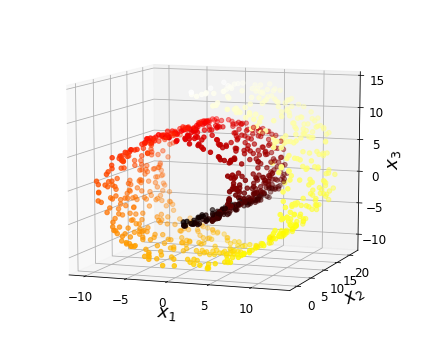

In [27]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("r_8_4")
plt.show()

Zapisywanie rysunku r_8_5


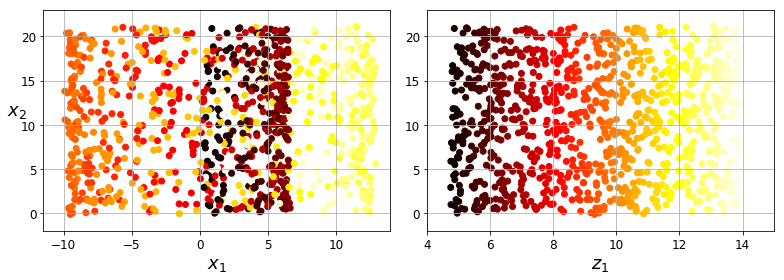

In [28]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("r_8_5")
plt.show()

Zapisywanie rysunku r_8_6_a


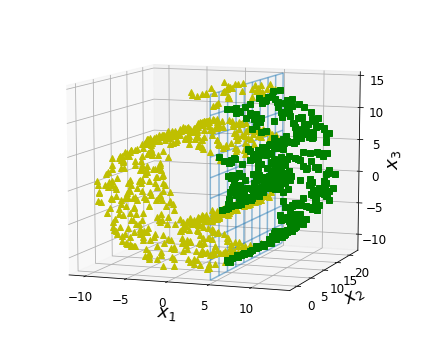

Zapisywanie rysunku r_8_6_b


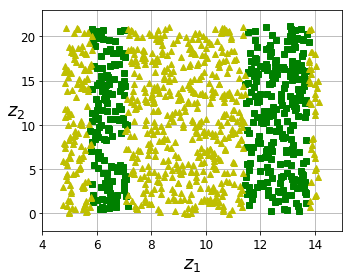

Zapisywanie rysunku r_8_6_c


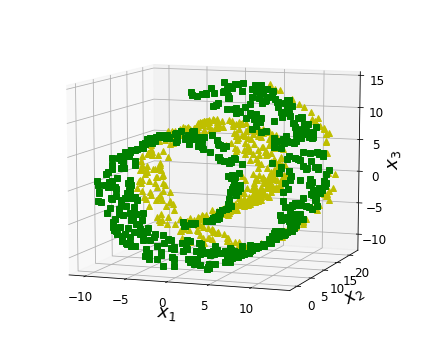

Zapisywanie rysunku r_8_6_d


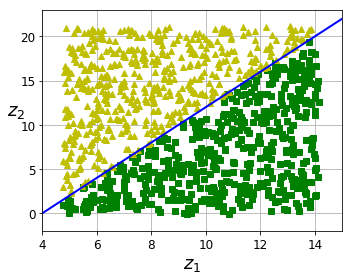

In [29]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("r_8_6_a")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("r_8_6_b")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("r_8_6_c")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("r_8_6_d")
plt.show()

# Analiza PCA

Zapisywanie rysunku r_8_7


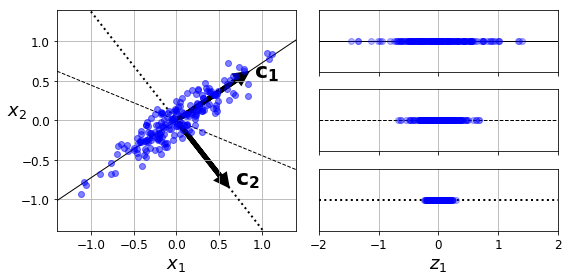

In [30]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # rozciąga
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # obraca

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("r_8_7")
plt.show()

# Kompresja zestawu danych MNIST

In [31]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [32]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [34]:
d

154

Zapisywanie rysunku r_8_8


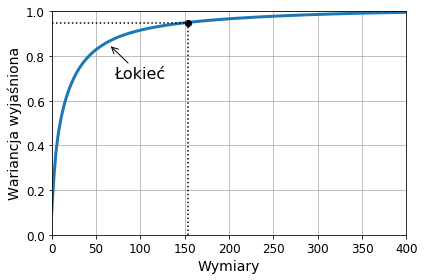

In [35]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Wymiary")
plt.ylabel("Wariancja wyjaśniona")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Łokieć", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("r_8_8")
plt.show()

In [36]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [37]:
pca.n_components_

154

In [38]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295709

In [39]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [40]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Zapisywanie rysunku r_8_9


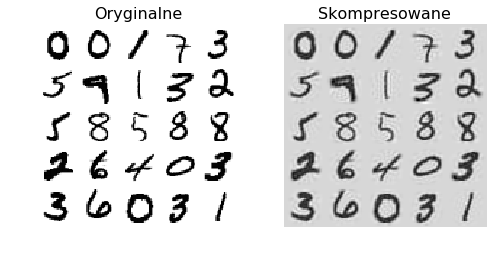

In [41]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Oryginalne", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Skompresowane", fontsize=16)

save_fig("r_8_9")

In [42]:
X_reduced_pca = X_reduced

## Przyrostowa analiza PCA

In [43]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # Nieukazane w książce
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [44]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

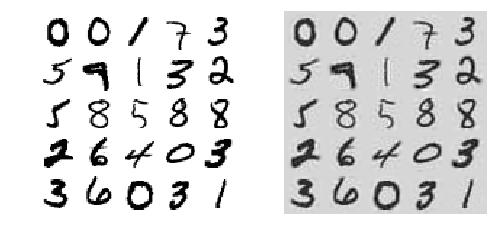

In [45]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [46]:
X_reduced_inc_pca = X_reduced

Porównajmy wyniki przekształcenia zbioru danych MNIST za pomocą standardowej i przyrostowej analizy PCA. Po pierwsze, średnie w obydwu wypadkach są równe:

In [47]:
np.allclose(pca.mean_, inc_pca.mean_)

True

Wyniki jednak nie są identyczne. Przyrostowa analiza PCA daje bardzo dobre, przybliżone rozwiązanie, nie jest jednak perfekcyjne:

In [48]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

### Korzystanie z funkcji memmap()

Stwórzmy strukturę `memmap()` i skopiujmy do niej dane MNIST. Zazwyczaj jest to wykonywane przez pierwszy program:

In [49]:
filename = "moje_dane_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Teraz usunięcie obiektu `memmap()` uruchomi funkcję finalizującą, dzięki której dane zostaną zapisane na dysku.

In [50]:
del X_mm

Następnie kolejny program może wczytać dane i użyć ich w procesie uczenia:

In [51]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [52]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Złożoność czasowa

Zmierzmy czas potrzebny dla standardowej, przyrostowej i losowej analizy PCA w zależności od liczby głównych składowych:

In [53]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} sekund".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 1.1 sekund
    IncrementalPCA: 22.5 sekund
    PCA: 1.0 sekund
n_components = 10
    PCA: 1.1 sekund
    IncrementalPCA: 23.8 sekund
    PCA: 1.1 sekund
n_components = 154
    PCA: 3.0 sekund
    IncrementalPCA: 31.0 sekund
    PCA: 2.7 sekund


Porównajmy teraz klasyczną i losową analizę PCA dla zbiorów danych o różnych rozmiarach (różnej liczbie próbek):

Text(0.5,1,'Złożoność czasowa analiz PCA i RPCA ')

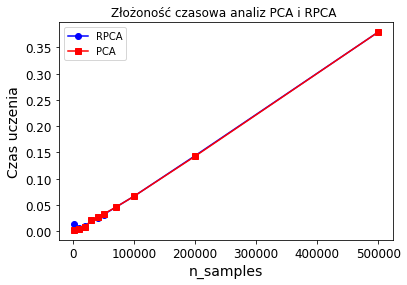

In [54]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Czas uczenia")
plt.legend(loc="upper left")
plt.title("Złożoność czasowa analiz PCA i RPCA ")

A teraz porównajmy ich wydajność dla zestawów danych składających się z 2000 przykładów, przy różnych liczbach cech:

Text(0.5,1,'Złożoność czasowa analiz PCA i RPCA 2 ')

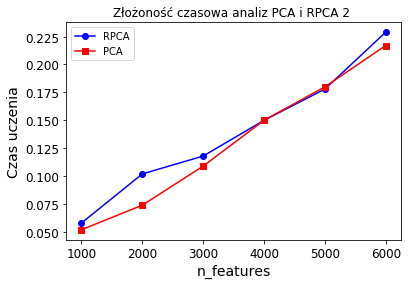

In [55]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Czas uczenia")
plt.legend(loc="upper left")
plt.title("Złożoność czasowa analiz PCA i RPCA 2 ")

# Jądrowa analiza PCA

In [56]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [57]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

C:\Users\Krzysztof\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


Zapisywanie rysunku r_8_10


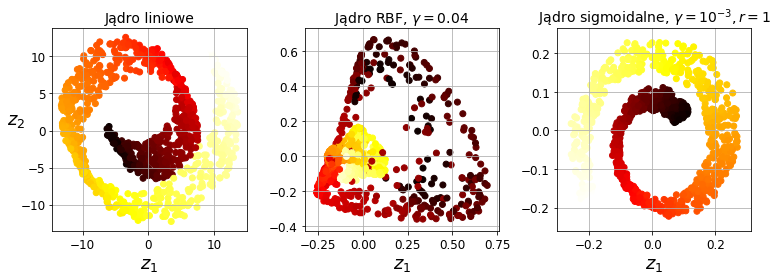

In [58]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Jądro liniowe"), (132, rbf_pca, "Jądro RBF, $\gamma=0.04$"), (133, sig_pca, "Jądro sigmoidalne, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("r_8_10")
plt.show()

Zapisywanie rysunku Przeciwobraz


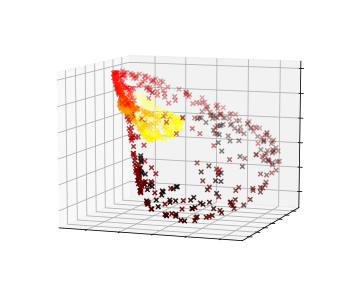

In [59]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("Przeciwobraz", tight_layout=False)
plt.show()

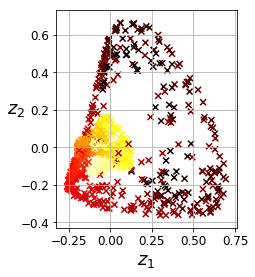

In [60]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                 

In [62]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [63]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [64]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.7863087957661

# Algorytm LLE

In [65]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [66]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Zapisywanie rysunku r_8_12


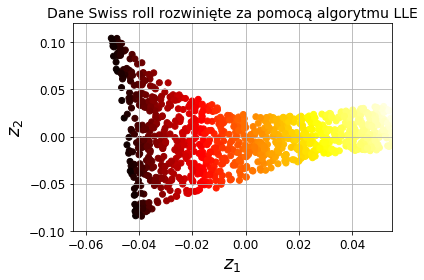

In [67]:
plt.title("Dane Swiss roll rozwinięte za pomocą algorytmu LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("r_8_12")
plt.show()

# Techniki MDS, Isomap i t-SNE

In [68]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [69]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [70]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [71]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

C:\Users\Krzysztof\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Zapisywanie rysunku r_8_13


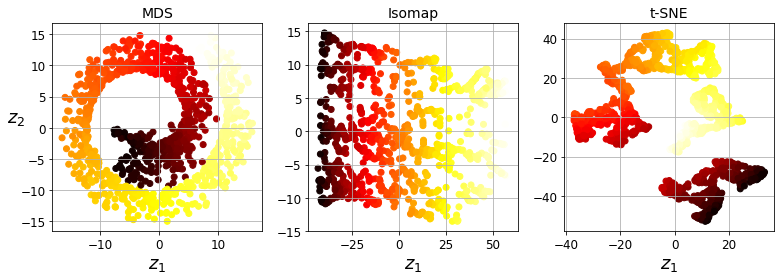

In [72]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("r_8_13")
plt.show()

# Rozwiązania ćwiczeń

## 1. do 8.

Zobacz dodatek A.

## 9.

*Ćwiczenie: wczytaj zbiór danych MNIST (omówiony w rozdziale 3.)  i podziel go na podzbiór uczący oraz testowy (pierwsze 60 000 próbek wyznacz do uczenia, a pozostałe 10 000 przeznacz do testowania).*

Zestaw MNIST wczytaliśmy już wcześniej. 

In [73]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

*Ćwiczenie: wyucz klasyfikator losowego lasu dla tego zestawu danych i zmierz czas, jaki mu to zajmie, a następnie oceń wydajność modelu za pomocą zbioru testowego.*

In [74]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [75]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [76]:
print("Proces uczenia zajął {:.2f}s".format(t1 - t0))

Proces uczenia zajął 32.86s


In [77]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

*Ćwiczenie: teraz użyj analizy PCA do zredukowania wymiarowości zestawu danych przy ustalonym współczynniku wariancji wyjaśnionej na poziomie 95%.*

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

*Ćwiczenie: wytrenuj nowy klasyfikator losowego lasu na zredukowanym zestawie danych i porównaj czas potrzebny na naukę modelu z poprzednim wynikiem. Czy proces nauki przebiegał znacznie szybciej?*

In [79]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [80]:
print("Proces uczenia zajął {:.2f}s".format(t1 - t0))

Proces uczenia zajął 76.35s


O nie! Proces uczenia zabiera teraz ponad dwukrotnie więcej czasu! Jak to możliwe? Jak już wiemy, redukcja wymiarowości nie zawsze prowadzi do skróconego czasu nauki: wszystko zależy od zbioru danych, modelu i algorytmu uczącego. Spójrz na rysunek 8.6. Jeżeli zamiast klasyfikatora losowego lasu wypróbujesz klasyfikator typu softmax, to zauważysz, że czas potrzebny na przeprowadzenie procesu uczenia stanie się trzykrotnie krótszy podczas stosowania analizy PCA. Za chwilę to zaprezentuję, najpierw jednak sprawdźmy precyzyję nowego klasyfikatora losowego lasu.

*Ćwiczenie: ponownie oceń wydajność modelu za pomocą podzbioru testowego: jakie uzyskujesz wyniki w stosunku do wcześniejszego modelu?*

In [81]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

Spadek wydajności po przeprowadzeniu redukcji wymiarowości jest powszechnym zjawiskiem, ponieważ tracimy w jej wyniku część użytecznego sygnału. Jednak spadek wydajności w tym przypadku jest dość drastyczny. Zatem analiza PCA nie okazała się tu pomocna: spowolniła proces uczenia i zmniejszyła wydajność. :(

Zobaczmy, czy uratuje nas regresja typu softmax:

In [82]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

C:\Users\Krzysztof\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [83]:
print("Proces uczenia zajął {:.2f}s".format(t1 - t0))

Proces uczenia zajął 9.34s


In [84]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

W porządku, zatem regresja metodą softmax wymaga znacznie więcej czasu do wyuczeniamodelu wobec tego zbioru danych niż klasyfikator losowego czasu, a do tego jej wydajność jest niższa dla zestawu testowego. Nie to nas jednak interesuje w tym momencie; chcemy przekonać się, w jakim stopniu analiza PCA jest w stanie dopomóc regresji typu softmax. Wyuczmy nasz model na zredukowanym zestawie danych:

In [85]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

C:\Users\Krzysztof\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [86]:
print("Proces uczenia zajął {:.2f}s".format(t1 - t0))

Proces uczenia zajął 4.01s


Nieźle! Redukcja wymiarowości czterokrotnie przyspieszyła proces uczenia. :) Sprawdźmy dokładność modelu:

In [87]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

Bardzo nieznaczny spadek wydajności, co stanowi rozsądną cenę za czterokrotne przyśpieszenie procesu uczenia, w zależności od zastosowań.

Zatem wygląda to tak: analiza PCA pozwala znacznie przyspieszyć uczenie modelu... ale nie zawsze!

## 10.

*Ćwiczenie: użyj algorytmu t-SNE w celu zredukowania zestawu danych MNIST do dwóch wymiarów i stwórz wykres wynikowy przy użyciu modułu Matplotlib. Możesz skorzystać z wykresu punktowego zawierającego 10 kolorów reprezentujących klasę docelową każdego obrazu.*

Zestaw MNIST został wczytany już wcześniej.

Redukcja wymiarowości dla wszystkich 60 000 obrazów zajmuje bardzo wiele czasu, dlatego przeprowadźmy te czynność wobec losowego podzbioru składającego się z 10 000 próbek:

In [88]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

Wykorzystajmy teraz technikę t-SNE do zredukowania wymiarowości do dwóch wymiarów, dzięki czemu będziemy w stanie wygenerować wykres zbioru danych:

In [89]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

Zastosujmy teraz funkcję `scatter()` modułu Matplotlib do stworzenia wykresu punktowego, w którym każda cyfra zostanie oznaczona innym kolorem:

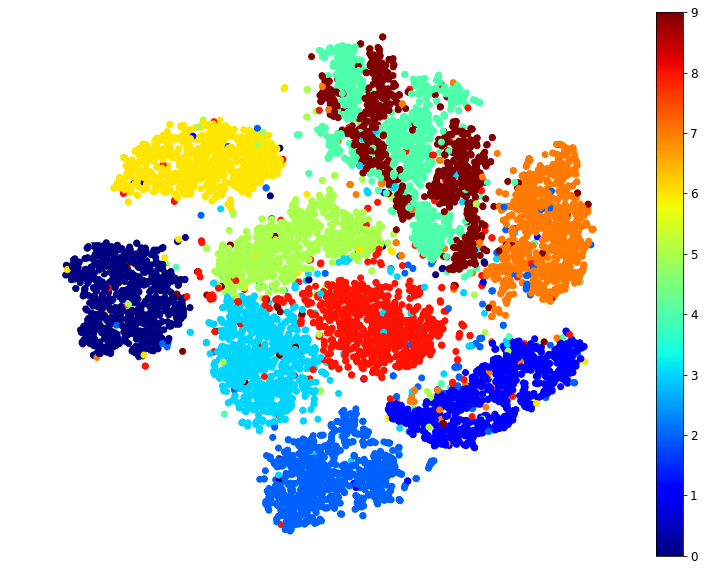

In [90]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Czyż nie jest piękny? :) Dzięki temu wykresowi wiemy, które liczby są z łatwością odróżniane od pozostałych (np. zera, szórki i ósemki są całkiem wyraźnie rozdzielonymi skupieniami), oraz z rozróżnieniem których cyfr możemy mieć problem (np. czwórkami i dziewiątkami, piątkami i trójkami itd.).

Skoncentrujmy się na cyfrach 2, 3 i 5, które zdają się pokrywać w dużym stopniu.

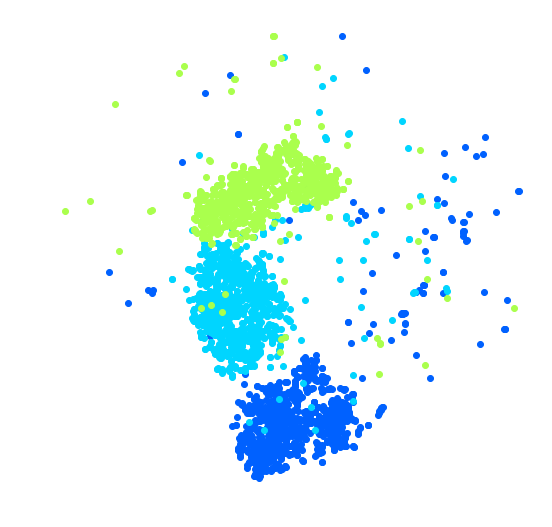

In [91]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Sprawdźmy, czy jesteśmy w stanie uzyskać lepszy obraz poprzez uruchomienie metody t-SNE wobec tych trzech cyfr:

In [92]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

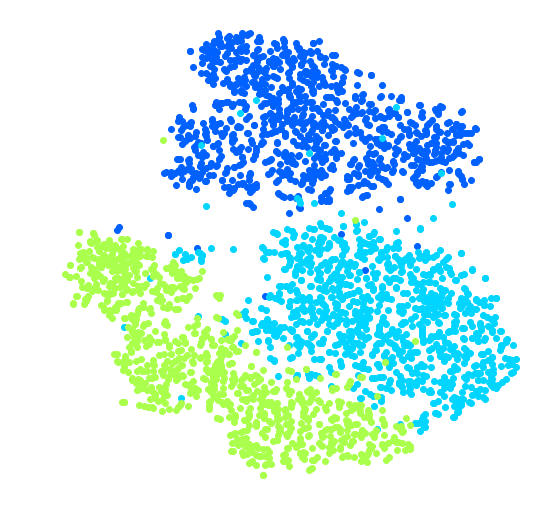

In [93]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Znacznie lepiej; teraz skupienia już nie pokrywają się w tak dużym stopniu. Jednak niektóre trójki ciągle są rozproszone po całym wykresie. Do tego istnieją dwa wyraźne skupienia dwójek, a także piątek. Byłoby miło, gdybyśmy mogli zwizualizować po kilka cyfr z każdego takiego skupienia, aby zrozumieć, czemu są one porozdzielane. Przystąpmy więc do dzieła.

*Exercise: Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.*

*Ćwiczenie: ewentualnie w miejscu każdej próbki możesz wstawić odpowiadającą jej kolorową cyfrę, a nawet stworzyć wykres składający się z miniaturowych wersji obrazów cyfr (jeżeli umieścisz na wykresie wszystkie obrazy, stanie się on nieczytelny, dlatego powinien być użyty losowy podzbiór próbek albo przykłady powinny być umieszczane tylko wtedy, gdy w pobliżu nie znajdują się już inne punkty). Powinieneś uzyskać ładny wykres z wyraźnie rozdzielonymi skupieniami cyfr.*

Stwórzmy funkcję `plot_digits()` rysującą wykres punktowy (podobny do powyższych wykresów) a także podpisywał poszczególne cyfry biorąc pod uwagę minimalną odległość pomiędzy nimi. Jeżeli są dostępne obrazy cyfr, to będą one umieszczane na wykresie. Inspirację dla tej implementacji stanowi jeden ze znakomitych przykładów wykorzystania modułu Scikit-Learn ([plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), bazujący na innym zbiorze obrazów cyfr).

In [94]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Przeskalujmy cechy wejściowe tak, aby mieściły się w zakresie od 0 do 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Tworzymy teraz listę współrzędnych dla dotychczas wyświetlanych cyfr na wykresie.
    # Udajemy, że jedna została już wygenerowana gdzieś daleko na wykresie
    # w celu uniknięcia instrukcji `if` w poniższej pętli
    neighbors = np.array([[10., 10.]])
    # Pozostała część kodu powinna być zrozumiała
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # pobiera bieżące osie z bieżącego wykresu
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

Wypróbujmy tę funkcję! Najpierw podpiszmy jedynie kolory cyfr:

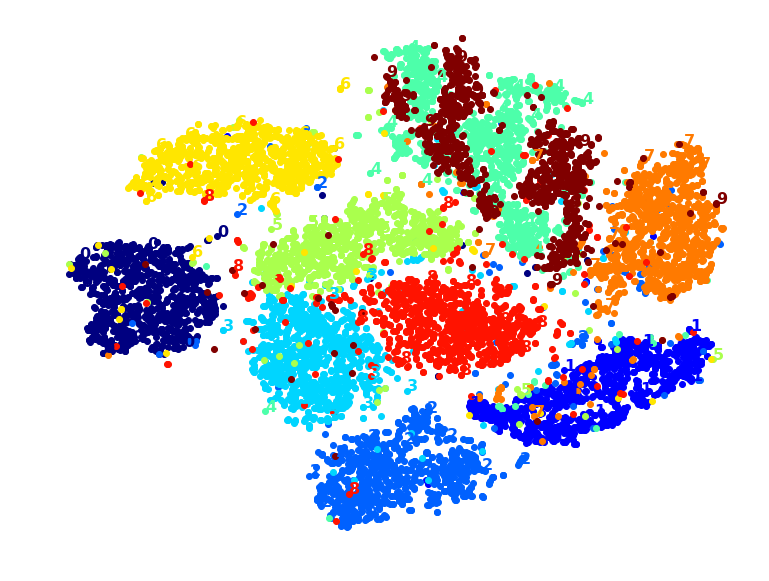

In [95]:
plot_digits(X_reduced, y)

Może być, ale nie wygląda to zbyt pięknie. Zobaczmy, jak będą prezentować się obrazy cyfr:

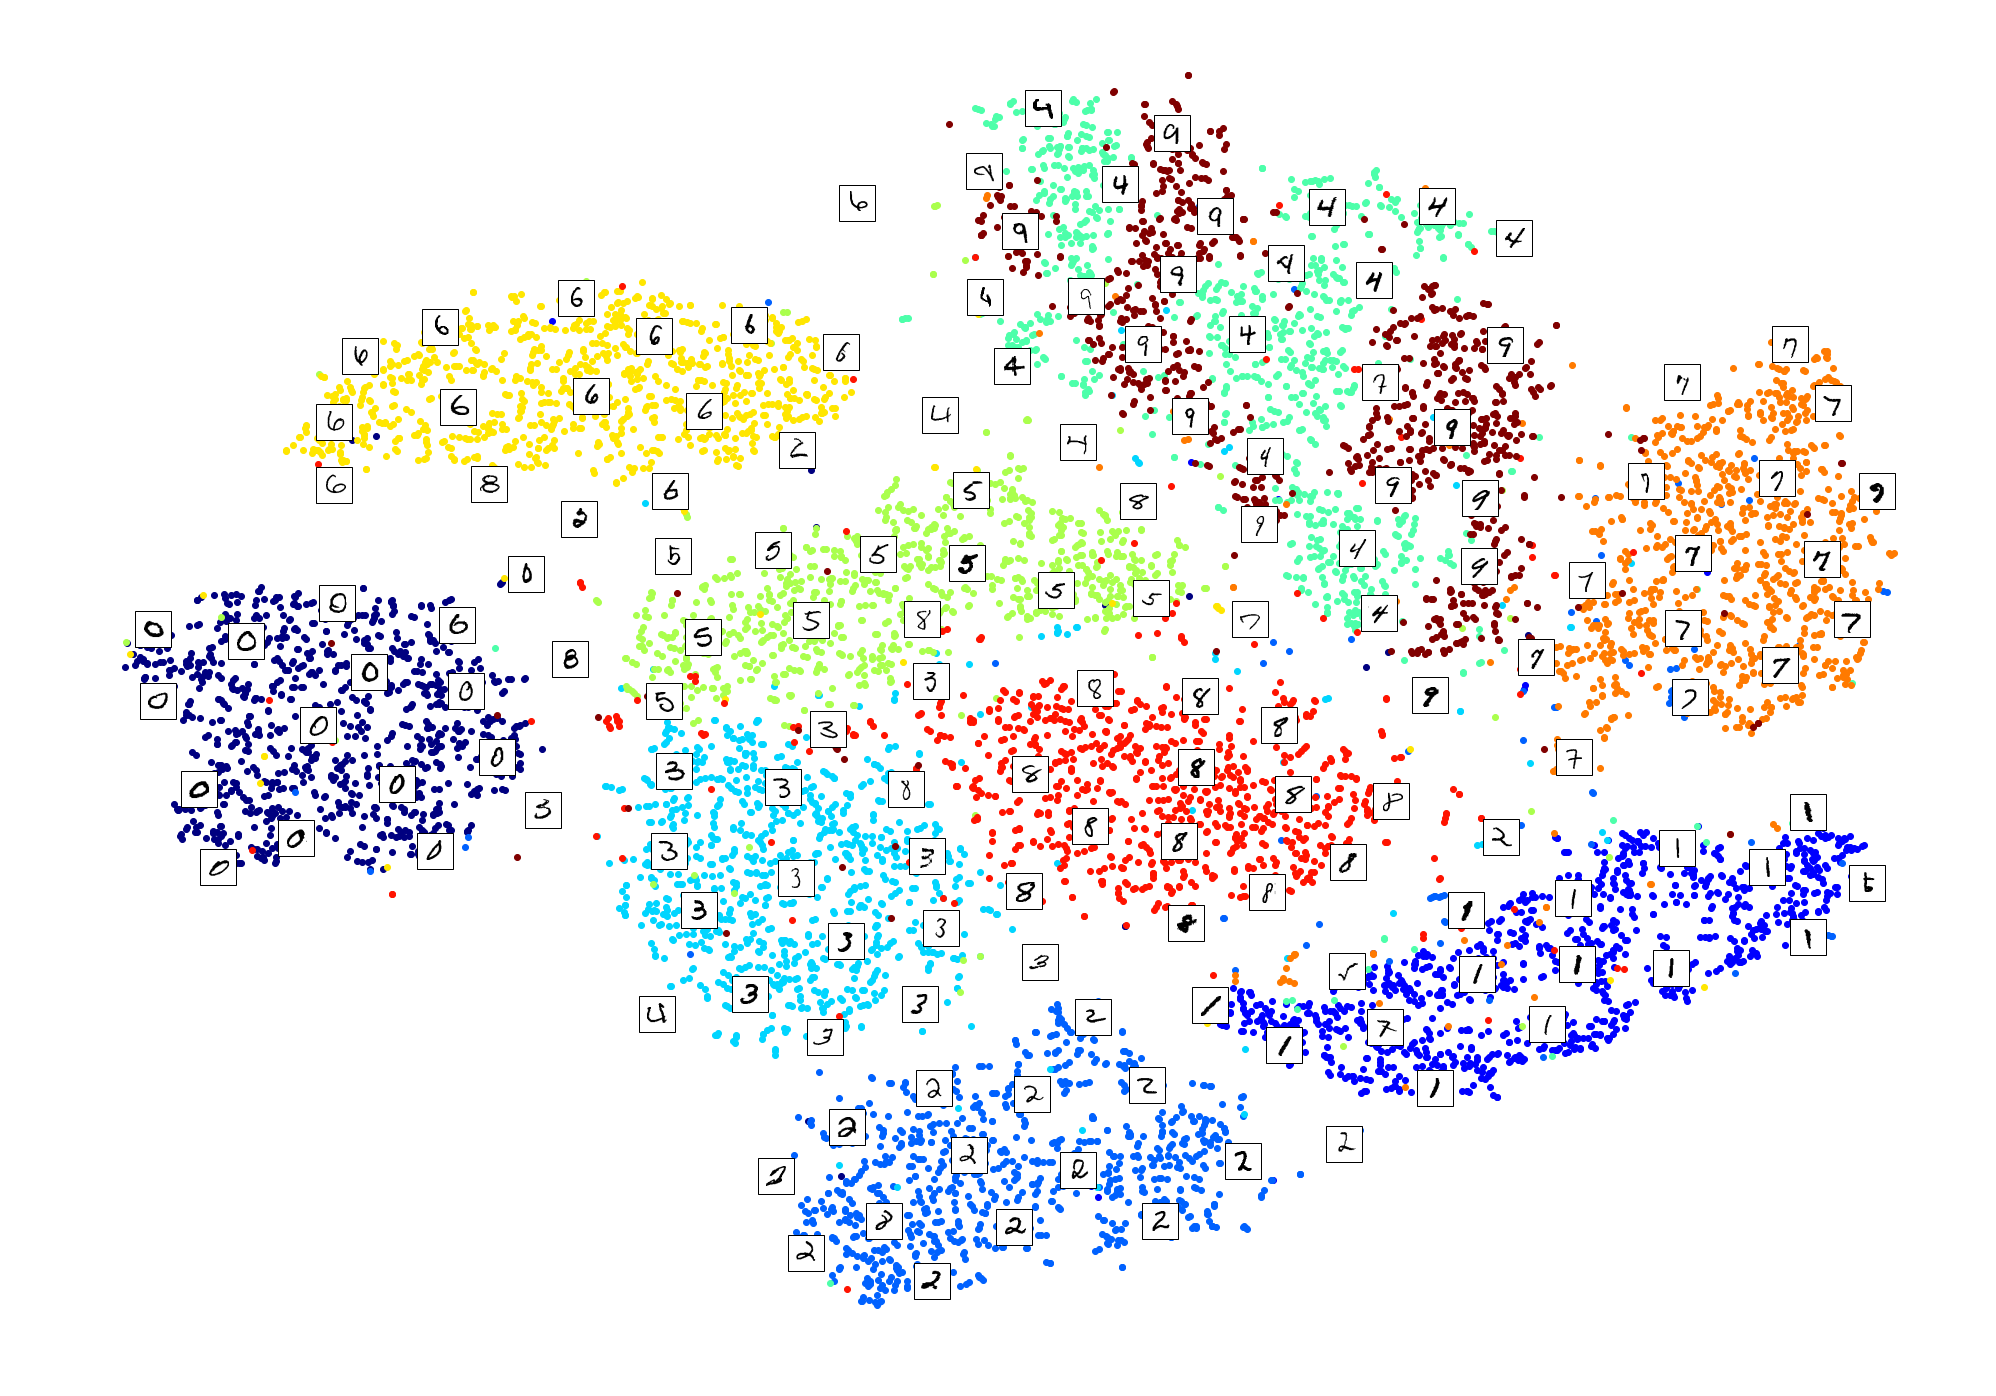

In [96]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

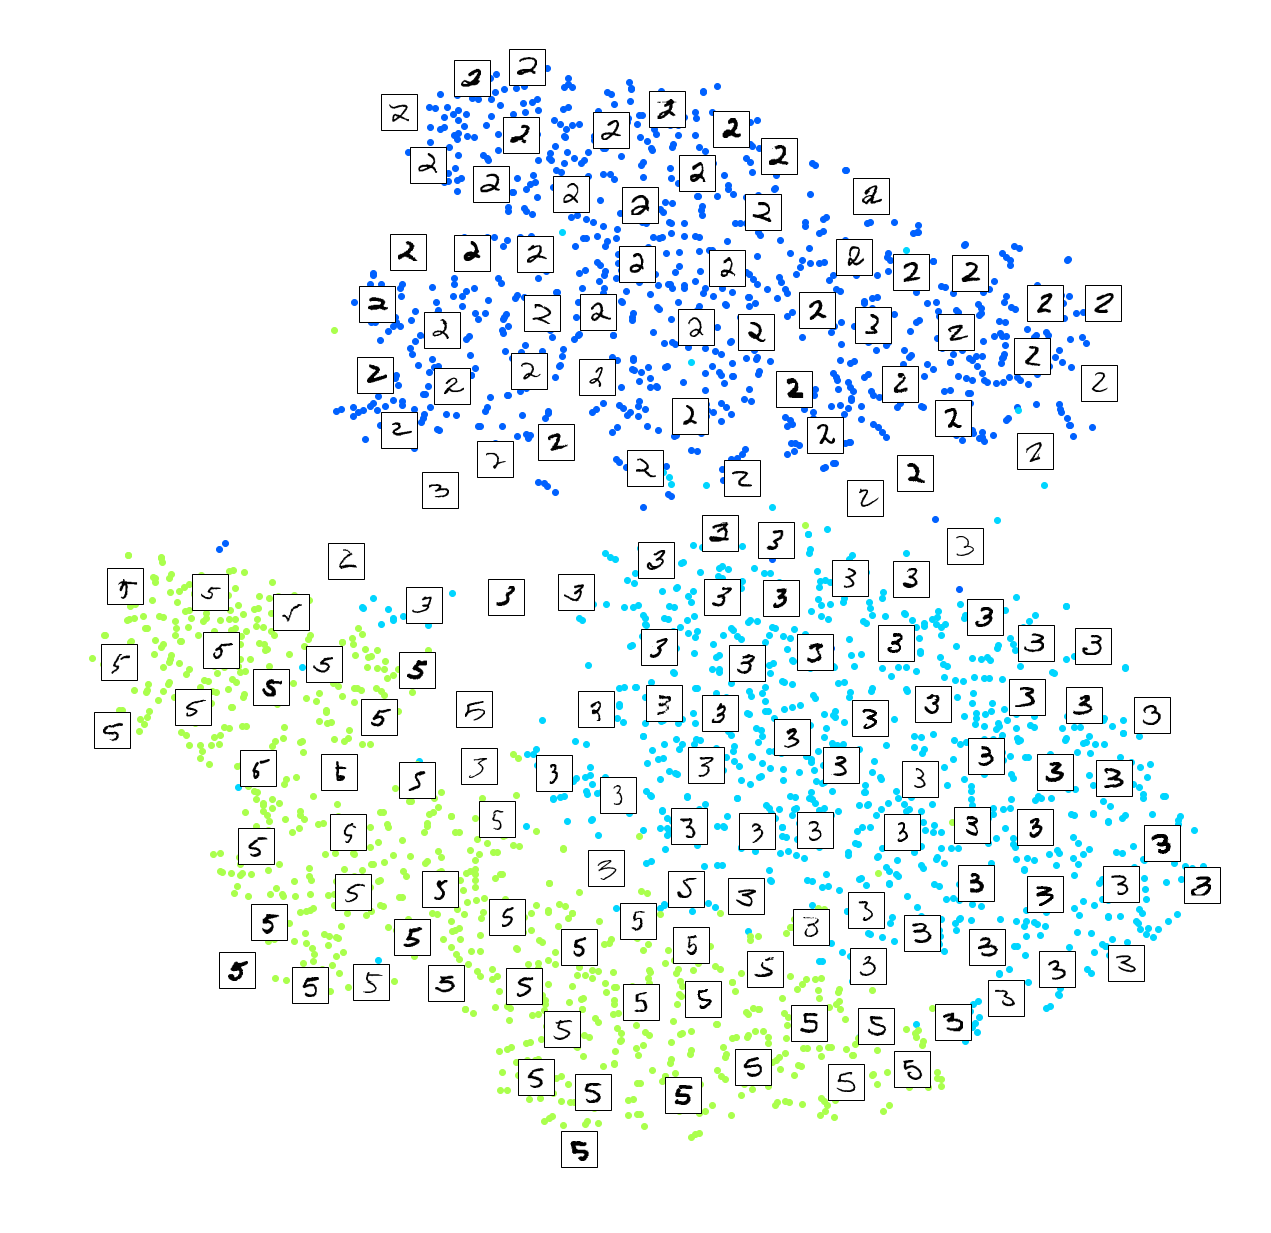

In [97]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

*Ćwiczenie: spróbuj skorzystać z innych algorytmów redukowania wymiarowości, takie jak PCA, LLE czy MDS i porównaj uzyskiwane za ich pomocą wizualizacje.*

Zacznijmy od analizy PCA. Sprawdzimy również, jak wiele czasu zajmie jej ten proces:

Analiza PCA zajęła 0.2s.


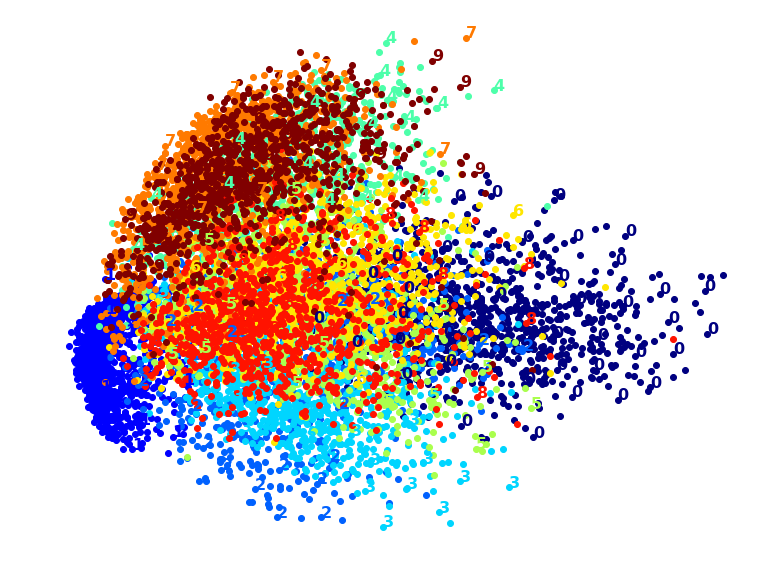

In [98]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("Analiza PCA zajęła {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

Rety, analiza PCA jest zdumiewająco szybka! Jednak mimo obecności kilku skupień, cyfry ciągle nadmiernie się na siebie nakładają. Sprawdźmy metodę LLE:

Metoda LLE zajęła 145.0s.


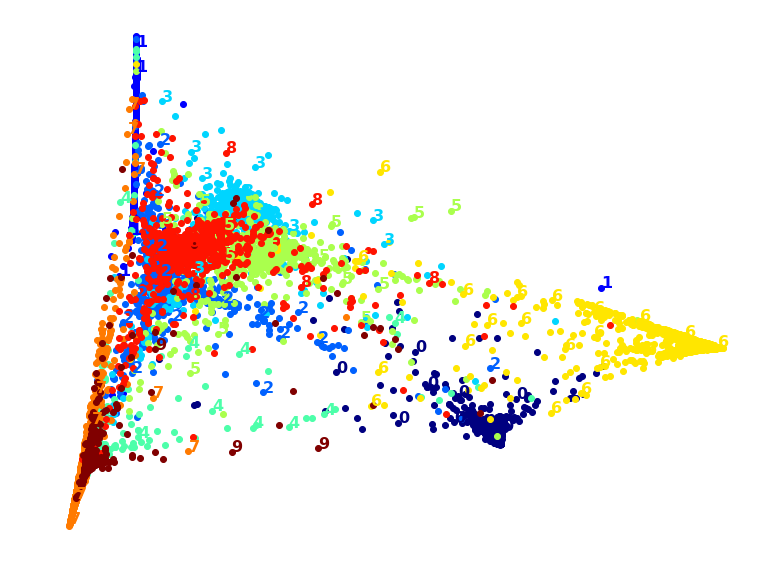

In [99]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("Metoda LLE zajęła {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

Zajęło to pewien czas, a i rezultat mógłby być lepszy. Zobaczmy, co się stanie, jeśli najpierw wprowadzimy analizę PCA przy zachowaniu 95% wariancji:

Kombinacja metod PCA+LLE zajęła 56.9s.


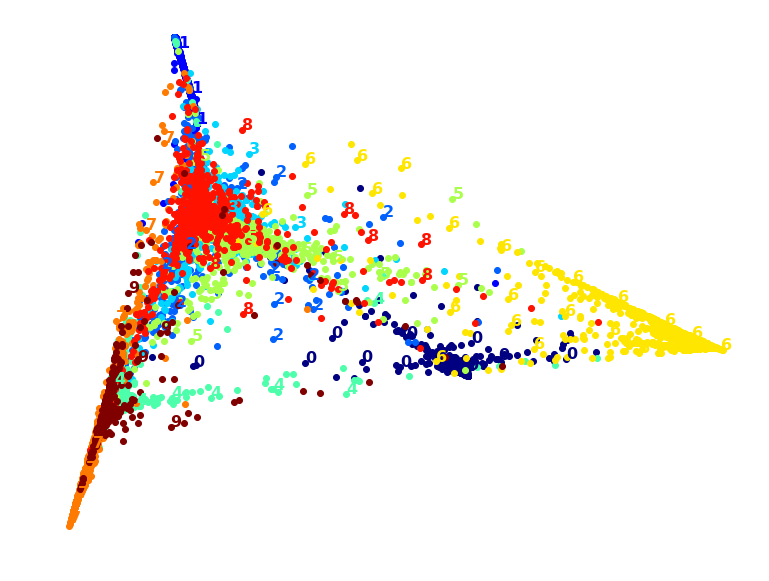

In [100]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("Kombinacja metod PCA+LLE zajęła {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

Wynik jest bardzo podobny do poprzedniego, ale tym razem osiągnęliśmy go niemal czterokrotnie szybciej.

Wypróbujmy technikę MDS. Proces ten zająłby stanowczo zbyt wiele czasu w przypadku 10000 próbek, dlatego ograniczmy na razie zbiór danych do 2000 obrazów:

Technika MDS zajęła 160.6s (dla jedynie 2,000 obrazów MNIST zamiast 10,000).


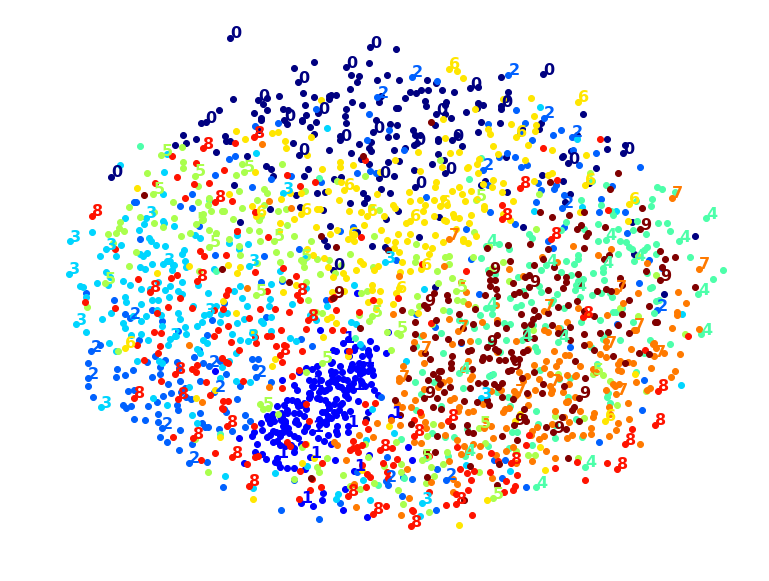

In [101]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("Technika MDS zajęła {:.1f}s (dla jedynie 2,000 obrazów MNIST zamiast 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

E tam. Nie wygląda to wcale dobrze, wszystkie skupienia przenikają się zanadto. Użyjmy najpierw analizy PCA, może chociaż przyspieszymy ten proces?

Kombinacja metod PCA+MDS zajęła 162.7s (dla 2,000 obrazów MNIST).


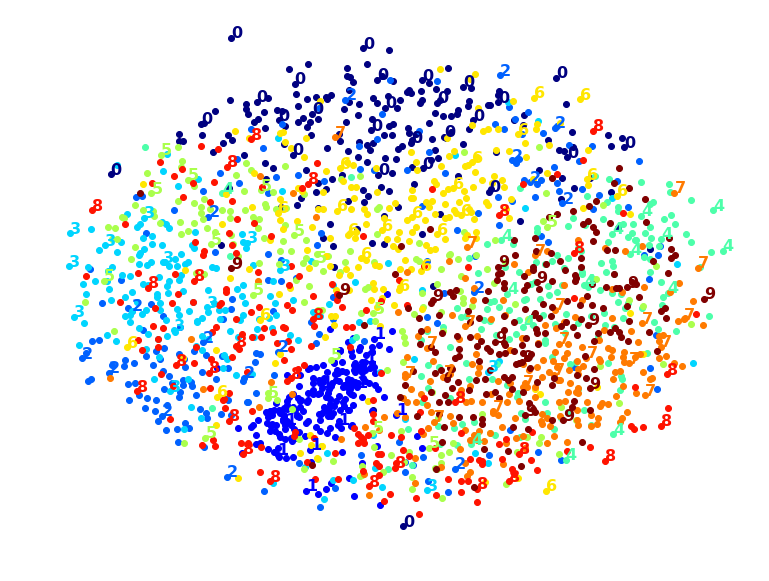

In [102]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("Kombinacja metod PCA+MDS zajęła {:.1f}s (dla 2,000 obrazów MNIST).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

Ten sam wynik bez poprawy czasu. Analiza PCA ani nie pomogła, ani nie zaszkodziła.

No to może analiza LDA:

C:\Users\Krzysztof\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Analiza LDA zajęła 1.6s.


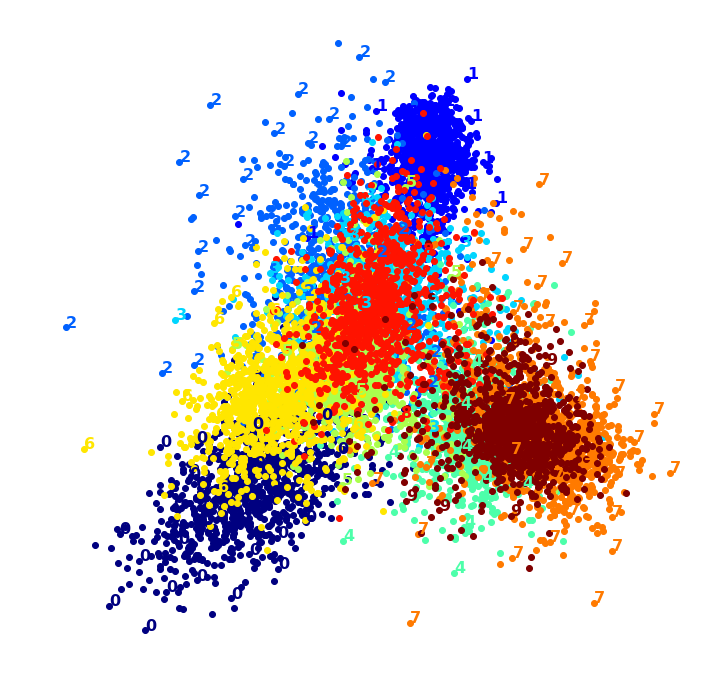

In [103]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("Analiza LDA zajęła {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

Technika ta jest bardzo szybka i początkowo wydaje się skuteczna, aż do chwili, gdy zorientujemy się, że kilka skupień w znacznym stopniu przenika się wzajemnie.

Jest całkiem oczywiste, że metoda t-SNE wygrała te małe zawody, prawda? Nie sprawdziliśmy czasu, jaki potrzebuje na wykonanie zadania, dlatego przyjrzyjmy mu się teraz:

Technika t-SNE zajęła 199.5s.


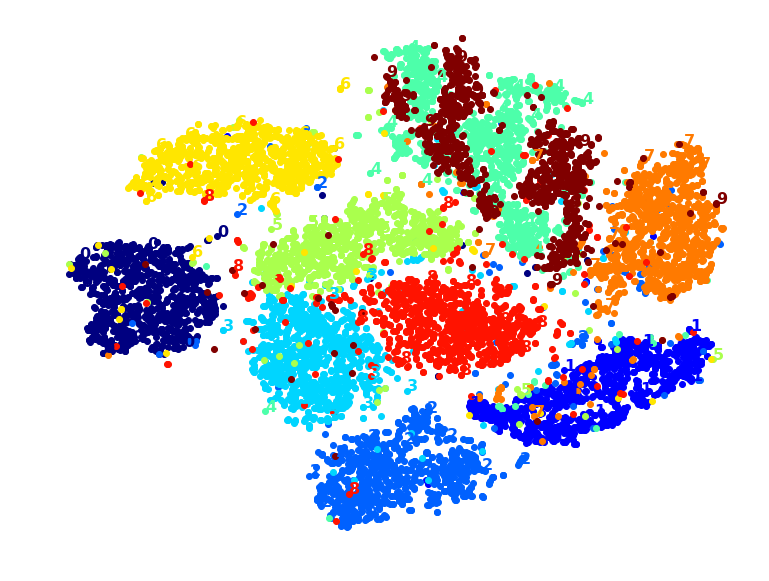

In [104]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("Technika t-SNE zajęła {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

Jest dwukrotnie wolniejsza od techniki LLE, ale i tak znacznie szybsza od metody MDS, a wyniki są całkiem imponujące. Sprawdźmy, czy uda nam się nieco przyspieszyć proces za pomocą analizy PCA:

Kombinacja metod PCA+t-SNE zajęła 114.1s.


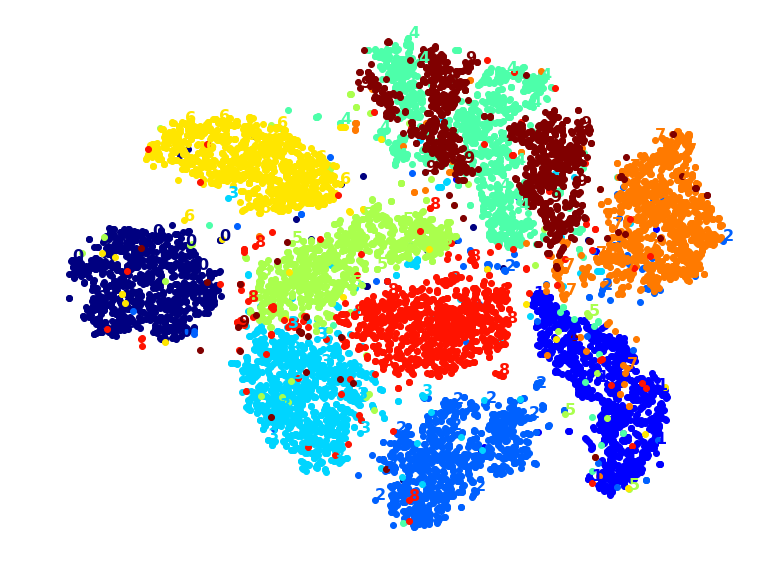

In [105]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("Kombinacja metod PCA+t-SNE zajęła {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Tak, analiza PCA przyspieszyła proces o mniej więcej 25% bez wpływania na rezultat. Mamy zwyciężczynię!